# 

In [1]:
import glob
import os
import json
import pickle  
import yaml 
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import utils_farouk2 as utils
plt.rcParams.update({"font.size": 20})
from hist.intervals import ratio_uncertainty


In [2]:
year = "2016APV"
channels = [ "ele","mu"]

years = ['2016APV']

samples_dir="/uscms/home/jieun201/nobackup/YOURWORKINGAREA/jan24/2016APV"

samples = [  # "WH", "ZH",
    "VH",    
    "ggF", "VBF", "ttH",#"HTauTau",
            "TTbar", "SingleTop",
           "WJetsLNu",
           "DYJets",      
      #     "WZQQ",  
          "Diboson", 
      #   "EWKvjets",
     #   "QCD",
           "Data",
    #"Fake",
          ]
samples_to_plot = samples


In [3]:
events_dict = utils.event_skimmer(year, channels, samples_dir, samples, "all", add_qcd_score=False, add_top_score=False, add_inclusive_score=False)

luminosity 19492.72
ATTENTION: EWKWminus_WToQQ will be skipped
ATTENTION: EWKWplus_WToQQ will be skipped
ATTENTION: EWKZ_ZToQQ will be skipped
is data
is data
is data
is data
is data
is data
is data
is data
is data
is data
ATTENTION: Fake will be skipped
ATTENTION: QCD_Pt_1000to1400 will be skipped
ATTENTION: QCD_Pt_1400to1800 will be skipped
ATTENTION: QCD_Pt_170to300 will be skipped
ATTENTION: QCD_Pt_1800to2400 will be skipped
ATTENTION: QCD_Pt_2400to3200 will be skipped
ATTENTION: QCD_Pt_300to470 will be skipped
ATTENTION: QCD_Pt_3200toInf will be skipped
ATTENTION: QCD_Pt_470to600 will be skipped
ATTENTION: QCD_Pt_600to800 will be skipped
ATTENTION: QCD_Pt_800to1000 will be skipped
luminosity 19436.16
ATTENTION: EWKWminus_WToQQ will be skipped
ATTENTION: EWKWplus_WToQQ will be skipped
ATTENTION: EWKZ_ZToQQ will be skipped
is data
is data
is data
is data
is data
is data
is data
is data
is data
is data
ATTENTION: Fake will be skipped
ATTENTION: QCD_Pt_1000to1400 will be skipped
ATTEN

In [4]:
def plot_hists(
    years, channels, hists, vars_to_plot, add_data, logy, add_soverb, only_sig, mult, text_="", blind_region=None
):
    # luminosity
    luminosity = 0
    for year in years:
        lum = 0
        for ch in channels:
            with open("../../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        luminosity += lum / len(channels)

    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

      #  print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if h.shape[0] == 0:  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in utils.signals]
        bkg_labels = [label for label in samples if (label and label not in signal_labels and (label not in ["Data"]))]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)
        order_dic = {}
        for bkg_label in bkg_labels:
         #   print('hist.keys', hists.keys())
            if "fj_pt" in hists.keys():
                #order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum().value                #March 21 )changed this to sum().value
            else:
                #order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum().value                    #March 21 )changed this to sum().value
        
        # data
        if add_data:
            data = h[{"samples": "Data"}]

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = mult
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
                fig, ax = plt.subplots(figsize=(8, 8))
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            
            for i, b in enumerate(bkg):
                np.asarray(b.values())[b.values() < 0] = 0.001
               # print('i,b', i,b)
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0   #check if this is for the ratio or not, 
            tot_val[tot_val_zero_mask] = 1
        tot_err = np.sqrt(tot.variances())   #March 21, changed this


        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
#*************BLIND REGION**********************************************************************************************
            if blind_region: 
                massbins = data.axes[-1].edges  
                lv = int(np.searchsorted(massbins, blind_region[0], "right"))  #get the third mass bin it seems
                rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)     
                data.view(flow=True)[lv:rv].value = 0
                data.view(flow=True)[lv:rv].variance = 0
          
            hep.histplot( data, ax=ax, histtype="errorbar", color="k",  capsize=4,yerr=True, label="Data",    **data_err_opts,  )

            if len(bkg) > 0:

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                ratio = data_val/tot_val

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")
#
                mc_stat_err = tot_err / tot_val  
                ratio_unc_band_upper = 1 + mc_stat_err
                ratio_unc_band_lower = 1 - mc_stat_err

                bin_edges = tot.axes[0].edges  
                bin_centers = tot.axes[0].centers

                print('bin_edges', bin_edges)
                print('bin centers', bin_centers)
                print('data_val', data_val)
                print('tot_val', tot_val)
                print('ratio', ratio)
 
                hep.histplot(
                    #data_val / tot_val,
                    ratio, bin_edges,
                  #  tot.axes[0].edges,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.fill_between(
                        #tot.axes[0].edges[:-1],  # X-values (bin edges)
                          bin_edges, 
         np.append(ratio_unc_band_lower, ratio_unc_band_lower[-1]),  # Extend last value
        np.append(ratio_unc_band_upper, ratio_unc_band_upper[-1]),  # Extend last value
        step="mid",  # Align with bin edges
                        color="gray",
                        alpha=0.2,  # Transparency level
                        label="MC Stat. Unc.",
                    )
                
                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot( bkg, ax=ax, stack=True, sort="yield", edgecolor="black",
                linewidth=1, histtype="fill", label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        ax.text(0.5, 0.9, text_, fontsize=14, transform=ax.transAxes, weight="bold")

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            ax.stairs( values=tot_signal.values() + np.sqrt(tot_signal.values()), baseline=tot_signal.values() - np.sqrt(tot_signal.values()),edges=sig.axes[0].edges, **errps,
  )

            if sax is not None:
                totsignal_val = tot_signal.values()
              #  print('totsignal_val', totsignal_val)
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(  soverb_val,  tot_signal.axes[0].edges, label="Total Signal", ax=sax,  linewidth=3,   color="tab:red",  )

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis
            
        elif rax is not None:
            ax.set_xlabel("")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis
            
            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        if len(channels) == 2:
            ax.legend(
                [hand[idx] for idx in range(len(hand))],
                [lab[idx] for idx in range(len(lab))],
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                title=f"Semi-Leptonic Channel",
            )        
        else:
            ax.legend(
                [hand[idx] for idx in range(len(hand))],
                [lab[idx] for idx in range(len(lab))],
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                title=f"{label_by_ch[ch]} Channel",
            )
        
        if logy:
            ax.set_yscale("log")
            ax.set_ylim(1e-1)
        hep.cms.lumitext(  "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20 )
       # hep.cms.lumitext(  "19.5 fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20 )
       # hep.cms.text("Work in Progress", ax=ax, fontsize=15)     


In [5]:
color_by_sample = {
    "ggF": "lightsteelblue",
    "VBF": "peru",
    # signal that is background
    
    #"WH": "tab:brown",
    #"ZH": "yellowgreen"
    "VH": "red", 
    "ttH": "tab:olive",
    # background
    "QCD": "tab:orange",
    "Fake": "tab:orange",
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "Diboson": "orchid",
    "SingleTop": "tab:cyan",
    "EWKvjets": "tab:grey",
    "DYJets": "tab:purple",
    "WZQQ": "khaki",
   
}
plot_labels = {    "ggF": "ggF",
   # "WH": "WH",
   # "ZH": "ZH",
    "VH": "VH",
    # "VH": "VH(WW)",
    # "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    "VBF": r"VBF",
    # "ttH": "ttH(WW)",
    "ttH": r"$t\bar{t}$H",
    "QCD": "Multijet",
    "Fake": "Fake",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "SingleTop": r"Single Top",
    "EWKvjets": "EWK VJets",
    "DYJets": r"Z$(\ell\ell)$+jets",
    "WZQQ": r"V$(qq)$",
                    }
#label_by_ch = { "lep": "Lepton",}
label_by_ch = {
    "mu": "Muon",
    "ele": "Electron"
}


In [6]:
#events_dict['ele']['TTbar']['weight_btag'].hist()


In [7]:
#my_list = list(events_dict['ele']['VH'])


bin_edges [ 40.  60.  80. 100. 120. 140. 160. 180.]
bin centers [ 50.  70.  90. 110. 130. 150. 170.]
data_val [202. 192. 227. 162.  88.  56.  43.]
tot_val [156.45890923 157.69517563 146.63395442 107.93346809  66.47498622
  38.00741848  25.46948059]
ratio [1.29107381 1.21753883 1.54807255 1.50092462 1.32380622 1.47339657
 1.68829513]


<Figure size 400x400 with 0 Axes>

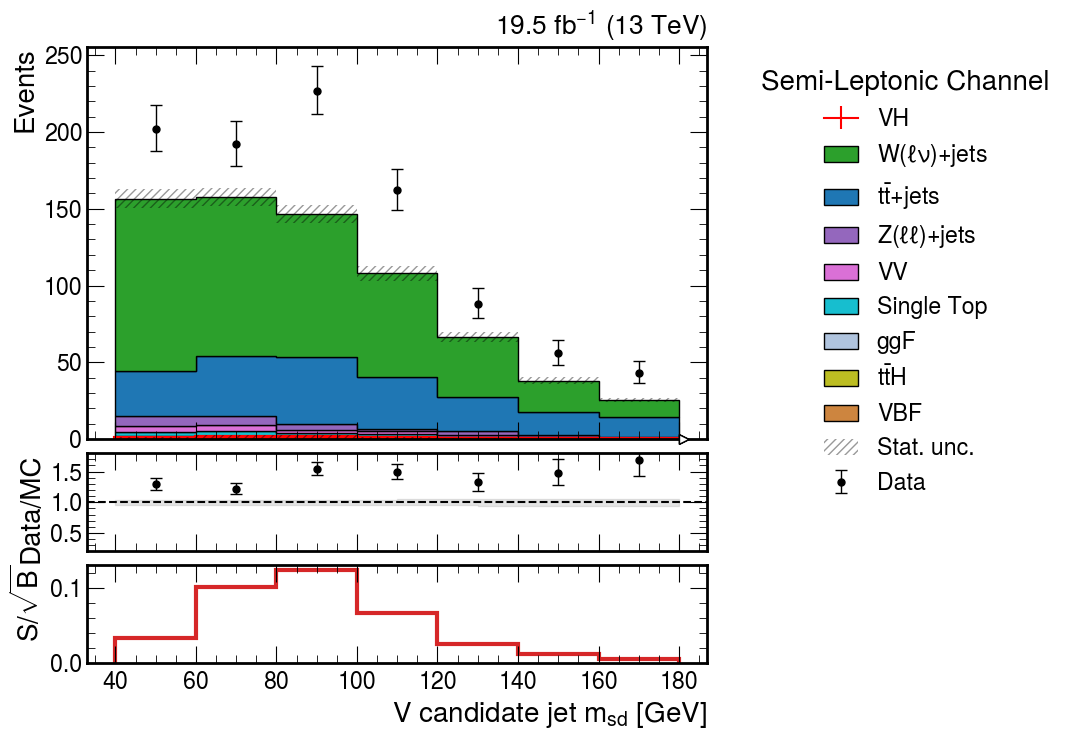

In [8]:
vars_to_plot = ["fj_mass"]
hists = {}
for var in vars_to_plot:            
    hists[var] = hist2.Hist( hist2.axis.StrCategory([], name="samples", growth=True),   utils.axis_dict[var], storage=hist2.storage.Weight(),)      
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            df = df[       (df["lep_fj_dr"] < 0.8 ) &  (df["lep_fj_dr"] > 0.03)     & (df['met_pt']> 30)  & (df["fj_pt"] > 250) 
            & (df["h_fj_pt"] > 250)  & (df["fj_mass"] > 40)    
             & (df['numberBJets_Medium_OutsideFatJets'] == 0)
            & (df['prob_H']  > 0.75)  & (df['prob_H'] > 0.905)
            
            ]            
            if var == "fj_mass":
                hists[var].fill( samples=sample,var=df["fj_mass"],
                    weight=df["event_weight"] )
plt.figure(figsize=(4,4))
plot_hists(  years, channels, hists, vars_to_plot, True, False,True,False, 1, text_="", )  
#plt.savefig(f"/home/jieun201/may18/boostedhiggs/python/preselectionPlots/{plotChannel}_vMass.png", bbox_inches='tight')

bin_edges [250.         286.66666667 323.33333333 360.         396.66666667
 433.33333333 470.         506.66666667 543.33333333 580.
 616.66666667 653.33333333 690.         726.66666667 763.33333333
 800.        ]
bin centers [268.33333333 305.         341.66666667 378.33333333 415.
 451.66666667 488.33333333 525.         561.66666667 598.33333333
 635.         671.66666667 708.33333333 745.         781.66666667]
data_val [246. 241. 184. 133.  57.  55.  42.  16.  22.  12.   7.   6.   2.   2.
   1.]
tot_val [178.67156629 165.5634685  121.23967097  82.6435979   56.17329987
  41.21202086  27.62969876  19.45269951  11.83805792   7.90559467
   5.994189     4.05248922   2.79027246   2.41759363   1.53061901]
ratio [1.37682791 1.45563512 1.51765506 1.60932006 1.01471696 1.33456207
 1.52010344 0.82250795 1.85841294 1.51791238 1.16779768 1.48057149
 0.71677588 0.82726889 0.65333044]


<Figure size 400x400 with 0 Axes>

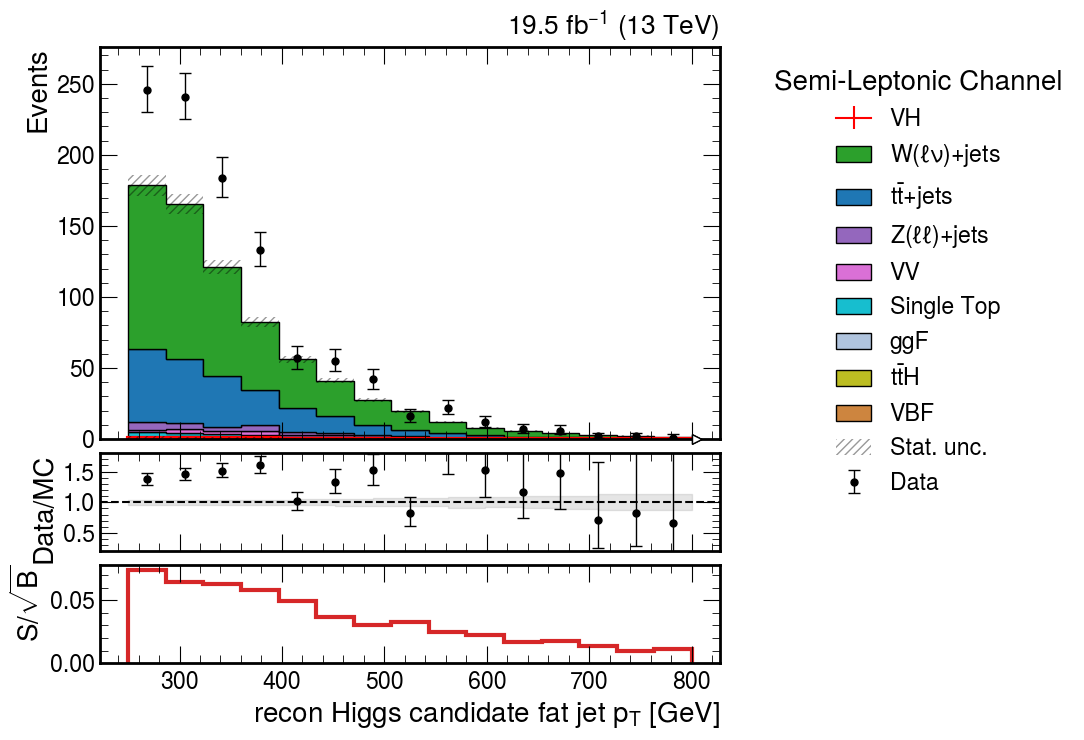

In [9]:
vars_to_plot = ["ReconHiggsCandidateFatJet_pt"]
hists = {}
for var in vars_to_plot:            
    hists[var] = hist2.Hist( hist2.axis.StrCategory([], name="samples", growth=True),   utils.axis_dict[var], storage=hist2.storage.Weight(),)      
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            df = df[       (df["lep_fj_dr"] < 0.8 ) &  (df["lep_fj_dr"] > 0.03)     & (df['met_pt']> 30)  & (df["fj_pt"] > 250) 
            & (df["h_fj_pt"] > 250)  & (df["fj_mass"] > 40)    
             & (df['numberBJets_Medium_OutsideFatJets'] == 0)
            & (df['prob_H']  > 0.75)  & (df['prob_H'] > 0.905)
            ]            
            if var == "ReconHiggsCandidateFatJet_pt":
                hists[var].fill( samples=sample,var=df["h_fj_pt"],
                    weight=df["event_weight"] )
plt.figure(figsize=(4,4))
plot_hists(  years, channels, hists, vars_to_plot, True, False,True,False, 1, text_="", )  
#plt.savefig(f"/home/jieun201/may18/boostedhiggs/python/preselectionPlots/{plotChannel}-higgsPT.png", bbox_inches='tight')

bin_edges [250.         295.83333333 341.66666667 387.5        433.33333333
 479.16666667 525.         570.83333333 616.66666667 662.5
 708.33333333 754.16666667 800.        ]
bin centers [272.91666667 318.75       364.58333333 410.41666667 456.25
 502.08333333 547.91666667 593.75       639.58333333 685.41666667
 731.25       777.08333333]
data_val [237. 208. 155. 140.  90.  63.  41.  32.  17.  15.   7.  10.]
tot_val [144.80933954 136.73324934 124.50960989  92.44848225  70.40101145
  52.51104701  33.31790113  22.96463748  18.13784234  11.80733763
   7.46709776   4.82307993]
ratio [1.63663477 1.5212101  1.24488383 1.51435693 1.27839072 1.19974755
 1.23056971 1.39344677 0.93726694 1.27039647 0.93744588 2.07336394]


<Figure size 400x400 with 0 Axes>

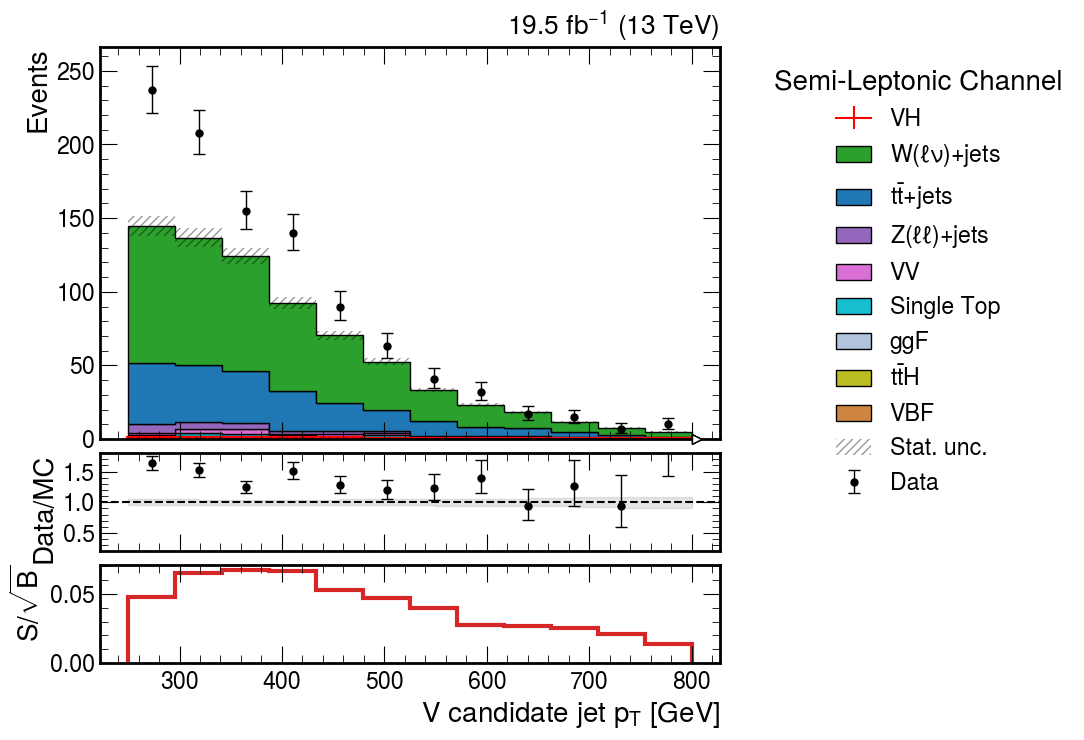

In [10]:
vars_to_plot = ["fj_pt"]
hists = {}
for var in vars_to_plot:            
    hists[var] = hist2.Hist( hist2.axis.StrCategory([], name="samples", growth=True),   utils.axis_dict[var], storage=hist2.storage.Weight(),)      
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            df = df[       (df["lep_fj_dr"] < 0.8 ) &  (df["lep_fj_dr"] > 0.03)     & (df['met_pt']> 30)  & (df["fj_pt"] > 250) 
            & (df["h_fj_pt"] > 250)  & (df["fj_mass"] > 40)    
             & (df['numberBJets_Medium_OutsideFatJets'] == 0)
            & (df['prob_H']  > 0.75)  & (df['prob_H'] > 0.905)]
            if var == "fj_pt":
                hists[var].fill( samples=sample,var=df["fj_pt"],
                    weight=df["event_weight"] )
plt.figure(figsize=(4,4))
plot_hists(  years, channels, hists, vars_to_plot, True, False,True,False, 1, text_="", )  
#plt.savefig(f"/home/jieun201/may18/boostedhiggs/python/preselectionPlots/{plotChannel}-Vpt.png", bbox_inches='tight')

bin_edges [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
bin centers [0.5125 0.5375 0.5625 0.5875 0.6125 0.6375 0.6625 0.6875 0.7125 0.7375
 0.7625 0.7875 0.8125 0.8375 0.8625 0.8875 0.9125 0.9375 0.9625 0.9875]
data_val [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1. 314. 341. 274. 101.]
tot_val [  1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.         204.8965635  242.14333081 199.51998715  87.45095918]
ratio [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.53248056 1.40825683
 1.373296   1.15493302]


<Figure size 400x400 with 0 Axes>

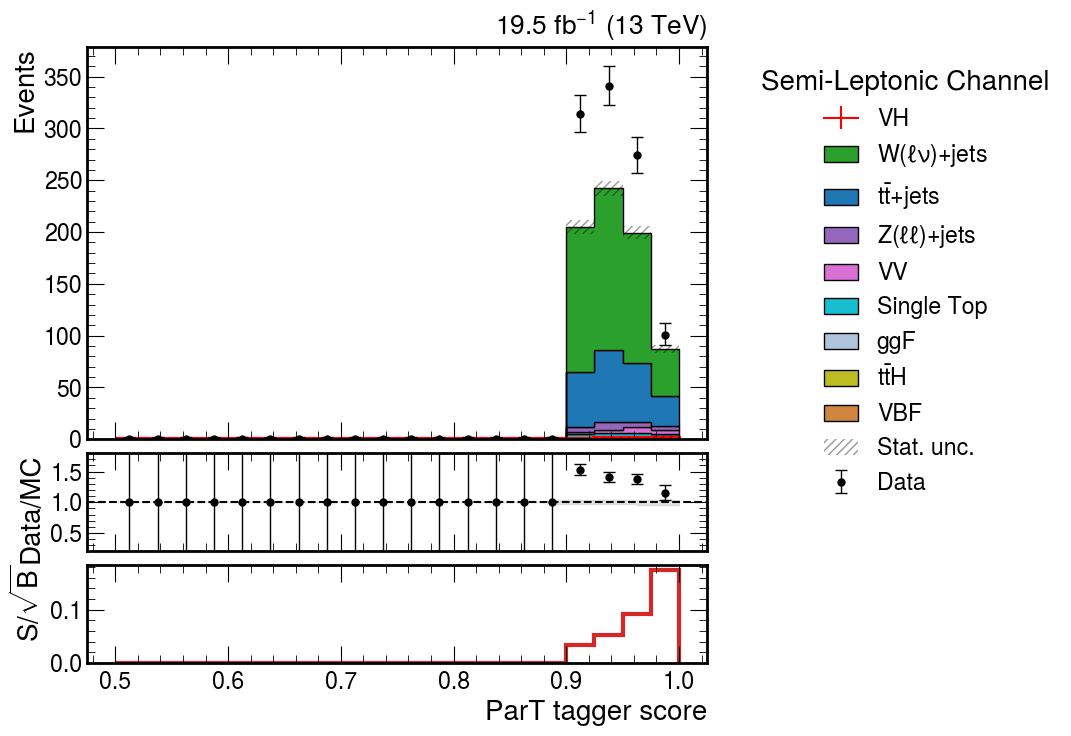

In [11]:
vars_to_plot = ["prob_H"]
hists = {}
for var in vars_to_plot:            
    hists[var] = hist2.Hist( hist2.axis.StrCategory([], name="samples", growth=True),   utils.axis_dict[var], storage=hist2.storage.Weight(),)      
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            df = df[       (df["lep_fj_dr"] < 0.8 ) &  (df["lep_fj_dr"] > 0.03)     & (df['met_pt']> 30)  & (df["fj_pt"] > 250) 
            & (df["h_fj_pt"] > 250)  & (df["fj_mass"] > 40)    
             & (df['numberBJets_Medium_OutsideFatJets'] == 0)
            & (df['prob_H']  > 0.75)  & (df['prob_H'] > 0.905)
            # &  (   ( df['mjj'] < 1000) | (df['deta'] < 2.5))
            #& (df['prob_H'] > 0.1)
            ]            
            if var == "prob_H":
                hists[var].fill( samples=sample,var=df["prob_H"],
                    weight=df["event_weight"] )
plt.figure(figsize=(4,4))
plot_hists(  years, channels, hists, vars_to_plot, True, False,True,False, 1, text_="", )  
#plt.savefig(f"/home/jieun201/may18/boostedhiggs/python/preselectionPlots/{plotChannel}-Vpt.png", bbox_inches='tight')

bin_edges [ 40.          50.66666667  61.33333333  72.          82.66666667
  93.33333333 104.         114.66666667 125.33333333 136.
 146.66666667 157.33333333 168.         178.66666667 189.33333333
 200.        ]
bin centers [ 45.33333333  56.          66.66666667  77.33333333  88.
  98.66666667 109.33333333 120.         130.66666667 141.33333333
 152.         162.66666667 173.33333333 184.         194.66666667]
data_val [ 2.  5.  7. 18. 24. 35. 60. 68. 67. 71. 68. 76. 44. 49. 47.]
tot_val [ 0.19792498  2.36271511  5.83366064  9.83289657 23.10522032 31.99703246
 37.15385668 48.79382992 58.33295147 53.66627494 47.49093077 46.58443374
 41.74468649 43.11839348 36.89495746]
ratio [10.10483868  2.11620943  1.19993267  1.83058978  1.0387263   1.09385144
  1.61490637  1.39361883  1.14857895  1.32299102  1.43185233  1.63144626
  1.05402636  1.13640598  1.27388682]


<Figure size 400x400 with 0 Axes>

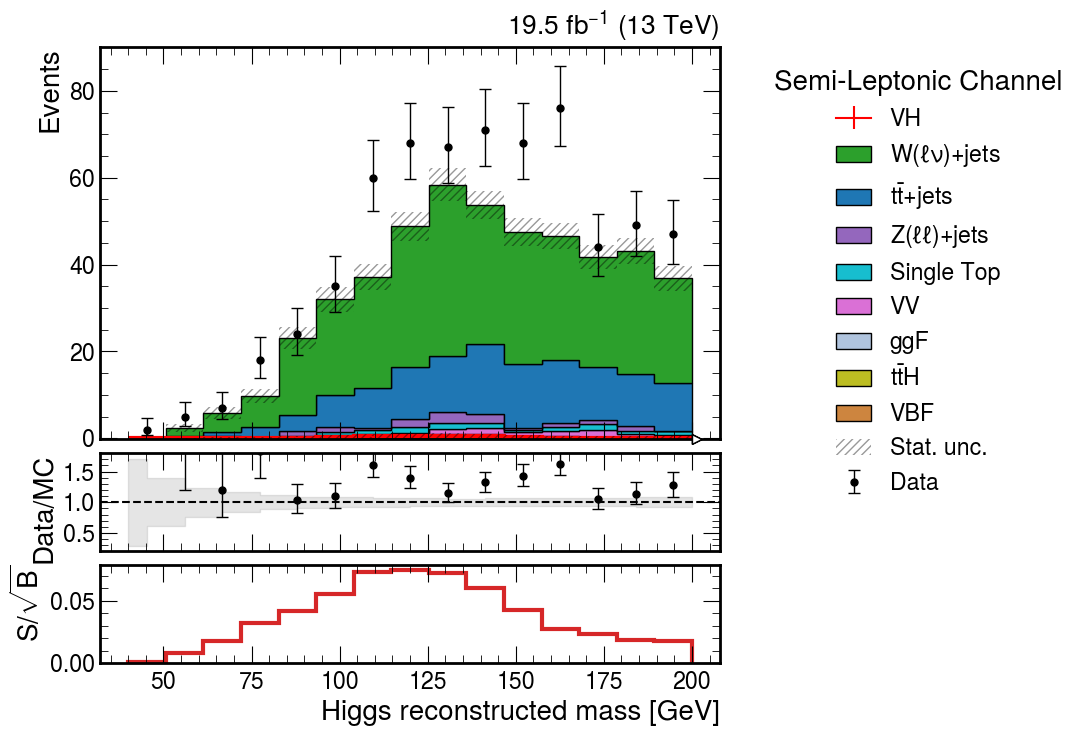

In [12]:
vars_to_plot = ["higgsMass"]
hists = {}
for var in vars_to_plot:            
    hists[var] = hist2.Hist( hist2.axis.StrCategory([], name="samples", growth=True),   utils.axis_dict[var], storage=hist2.storage.Weight(),)      
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            df = df[       (df["lep_fj_dr"] < 0.8 ) &  (df["lep_fj_dr"] > 0.03)     & (df['met_pt']> 30)  & (df["fj_pt"] > 250) 
            & (df["h_fj_pt"] > 250)  & (df["fj_mass"] > 40)    
             & (df['numberBJets_Medium_OutsideFatJets'] == 0)
            & (df['prob_H']  > 0.75)  & (df['prob_H'] > 0.905)       ]
            
            if var == "higgsMass":
                hists[var].fill( samples=sample,var=df["higgsMass"],
                    weight=df["event_weight"] )
plt.figure(figsize=(4,4))
plot_hists(  years, channels, hists, vars_to_plot, True, False,True,False, 1, text_="", )  
#plt.savefig(f"/home/jieun201/may18/boostedhiggs/python/preselectionPlots/{plotChannel}-hmass.png", bbox_inches='tight')